In [167]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import sklearn.metrics as skm

In [168]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv', 'rb'), delimiter=',')

In [169]:
# Limit count of 7s to 500

indexOf7 = np.where(data[:, 0]==7)[0] # indexes where labels are 7
countOf7ToRemove = indexOf7.size - 500 # count of 7s to REMOVE, so that the remaining are 500
indexOf7ToRemove = np.random.choice(indexOf7, countOf7ToRemove, replace=False) # index of 7s to remove is randamoly chosen
data = np.delete(data, indexOf7ToRemove, axis=0) # deleted 7s rows
np.where(data[:, 0]==7)[0].shape # count of 7s left

(500,)

In [170]:
# extract labels and features
labels = data[:,0]
data = data[:,1:]
# normalize the data to a range of [0, 1]
dataNorm = data/np.max(data)

In [171]:
counts = np.unique(labels, return_counts=True)
counts

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([1962, 2243, 1989, 2021, 1924, 1761, 2039,  500, 1912, 2023]))

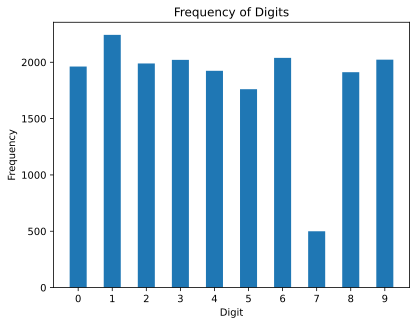

In [172]:
plt.bar(counts[0],counts[1], .5)
plt.xticks(range(10),range(10))
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Frequency of Digits')
plt.show()

In [173]:
# Convert to tensor
dataT = torch.Tensor(dataNorm).float()
labelsT = torch.Tensor(labels).long()

In [174]:
# split the data
train_data, test_data, train_label, test_label = train_test_split(dataT, labelsT, train_size=0.9)
train_dataT = TensorDataset(train_data, train_label)
test_dataT = TensorDataset(test_data, test_label)

train_loader = DataLoader(train_dataT, batch_size=32, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataT, batch_size=test_dataT.tensors[0].shape[0])

In [175]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.input = nn.Linear(784, 64)
        self.h1 = nn.Linear(64, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.output(x)
        # x = torch.log_softmax(self.output(x), axis=1)
        # log_softmax() because of NLLLoss instead of CrossEntropyLoss

        return x

In [176]:
def getModel():
    ANN = Model()
    lossFunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=ANN.parameters(), lr=0.01)

    return ANN, lossFunction, optimizer

In [177]:
def trainModel(ANN, lossFunction, optimizer):
    epochs = 10

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = ANN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = ANN(X)

        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN

In [178]:
ANN, lossFunction, optimizer = getModel()
trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)

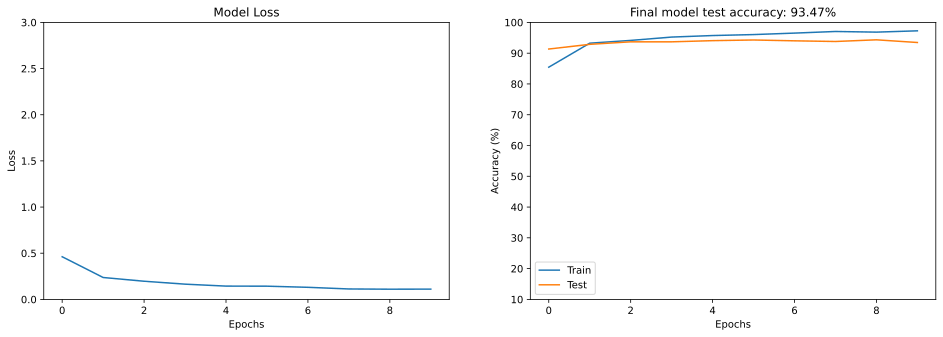

In [179]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')
ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [180]:
# train predictions

yHat = ANN.forward(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat, axis=1)

In [181]:
# test predictions

yHat = ANN.forward(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat, axis=1)

In [182]:
# Brief aside on computing precision et al. in multiclass data:
# There are now 10 classes, so there are 10 precision values.


## option 1: compute precision for each class (each number)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average=None)

array([0.99360837, 0.99117647, 0.98060942, 0.95418994, 0.99228487,
       0.93932039, 0.98480738, 0.84230769, 0.95238095, 0.97300402])

In [183]:
## option 2: compute average precision, weighted by N
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')

0.9706502048342652

In [184]:
## option 3: compute average precision, unweighted (same as 'weighted' if category N's are equal)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='macro')

0.9603689499690917

In [185]:
# 'macro' average is the normal average i.e. sum of all numbers divided by count of numbers -> (score1 + score2)/count of numbers
# 'weighted' average is the ((weight1)*score1 + (weight2)*score2)/sum of weights
# if all the categories have same size then weighted and macro are same

In [186]:
train_predictions

tensor([2, 0, 9,  ..., 9, 4, 9])

In [187]:
train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1], train_predictions)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')

# test
test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1], test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')

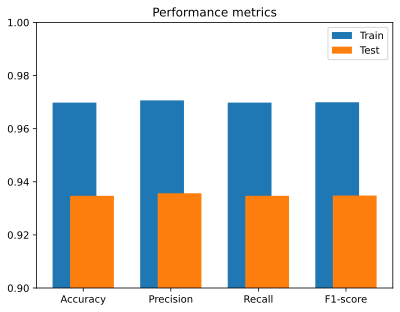

In [188]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.9,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

### Above plot shows that however we removed bunch of 7s but the scores are still balanced. Removing 7s didn't have any specific effect on the scores (because these are average scores of all the categories) but it can have specific effect on the category 7.

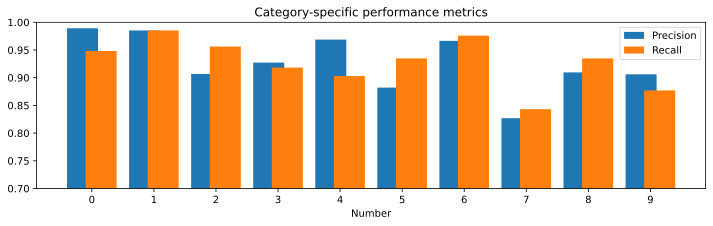

In [192]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average=None) # not averaging, calculating for each category
recall    = skm.recall_score   (test_loader.dataset.tensors[1], test_predictions, average=None) # not averaging, calculating for each category


fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.ylim([.7,1])
plt.xlabel('Number')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance metrics')
plt.show()

### Running the model multiple times will result in different scores for category 7. Sometimes precision will be high and sometimes recall will be high.

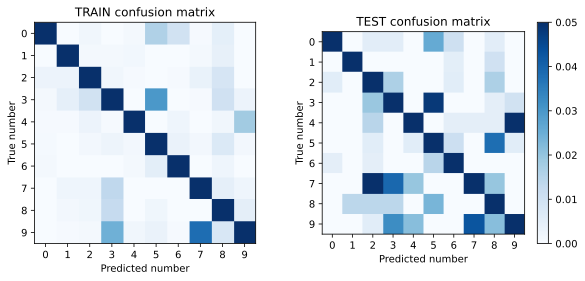

In [190]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions,normalize='true')
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions,normalize='true')

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during TEST
a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

### Here we expect that diagonals are dark and off-diagonals are light.

### Having an unbalanced data is not necessarily bad, it depends on the variety of factors like model design etc. 